In [170]:
import os
import seaborn
import bq_helper
import folium
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bq_helper import BigQueryHelper
from sklearn import linear_model
from sklearn.model_selection import train_test_split

## Step 1: Import Housing and Crime Data

### Housing data

In [705]:
#folder location
dir = '/Users/wilfried/Desktop/Courses/Year3/ChicagoCrimeProject/'

#read the chicago housing price data
df_house = pd.read_csv(dir+'Zillow Neighborhood Housing Price.csv')
df_house_chicago = df_house.loc[df_house['City']=='Chicago']

#read the chicago census data
df_commu = pd.read_csv(dir+'Chicago 2010 Census.csv')
df_commu = df_commu[['Geog','GeogKey', 'Total Population', 'Total Housing Units']]
df_commu = df_commu.rename(columns={'Geog':'community_area',\
                'GeogKey':'community_area_code', 'Total Population':'population'})

In [706]:
#create a dictonary that maps community area code to community area full name
dict_commu = pd.Series(df_commu.community_area.values,index=df_commu.community_area_code).to_dict()

In [707]:
#clean the chicago housing price data
#get rid of unusable community_areas
list_commu = list(dict_commu.values())
df_house_chicago['in_community_list'] = df_house_chicago['RegionName'].apply(lambda x: x in list_commu)
df_house_chicago = df_house_chicago[df_house_chicago['in_community_list']==True]

#get rid of irrelevant columns
list_labels_to_drop = ['RegionID','SizeRank','RegionType','StateName','State','City','Metro','CountyName','in_community_list']
df_house_chicago = df_house_chicago.drop(list_labels_to_drop,axis=1)
df_house_chicago = df_house_chicago.drop(df_house_chicago.columns[1:61],axis=1)

In [708]:
df_house_chicago = df_house_chicago.drop(df_house_chicago.columns[1:25],axis=1)
#df_house_chicago

In [709]:
#reformat time label
list_time_labels = df_house_chicago.columns[1:].tolist()
list_labels_update = ['community_area']
for i in list_time_labels:
    list_labels_update.append(i[:-3])
df_house_chicago.columns = list_labels_update

#drop missing values
df_house_chicago = df_house_chicago.dropna()

df_house_chicago = df_house_chicago.sort_values('community_area')
#df_house_chicago

In [710]:
#reformat the dataframe, group by community area, month
df_house_chicago_reindex = df_house_chicago.melt(id_vars=['community_area'],var_name='month',value_name='price')
df_house_chicago_reindex = df_house_chicago_reindex.set_index(['community_area','month'])
df_house_chicago_reindex = df_house_chicago_reindex.sort_values(by=['community_area','month'])
#df_house_chicago_reindex

In [711]:
#create a list of community area in the housing dataframe
list_relevant_commu = df_house_chicago['community_area'].tolist()

### Crime Data

In [473]:
#query from google cloud and create a dataframe
chicago_crime = bq_helper.BigQueryHelper(active_project='bigquery-public-data',dataset_name='chicago_crime')
bq_assistant = BigQueryHelper('bigquery-public-data','chicago_crime')
query = """
          SELECT
              date,year,primary_type,longitude,latitude,description,location_description,arrest,domestic,community_area,location
          FROM
          `bigquery-public-data.chicago_crime.crime`
          """
df_crime0 = chicago_crime.query_to_pandas_safe(query)

In [475]:
#clean up the dataframe and group by community area, month
df_crime = df_crime0.dropna()
df_crime = df_crime.sort_values(by=['date'])
df_crime = df_crime.rename(columns={'community_area':'community_area_code'})
df_crime['community_area_code'] = df_crime['community_area_code'].apply(lambda x: int(x))
df_crime = df_crime[df_crime['community_area_code']!=0]
df_crime['community_area'] = df_crime['community_area_code'].map(dict_commu)
df_crime['in_relevant_commu'] = df_crime['community_area'].apply(lambda x: x in list_relevant_commu)
df_crime = df_crime[df_crime['in_relevant_commu']==True]
df_crime = df_crime.drop(['in_relevant_commu'],axis=1)

df_crime['date'] = df_crime['date'].dt.tz_localize(None)
df_crime['month'] = df_crime['date'].dt.to_period('M')
df_crime['month'] = df_crime['month'].astype(str)

df_crime_reindex = df_crime.set_index(['community_area','month'])
df_crime_reindex = df_crime_reindex.sort_values(by=['community_area','month'])
df_crime_reindex = df_crime_reindex[df_crime_reindex['year']>2002]

### Joining Housing and Crime Data

In [712]:
#joining and cleaning the two dataframes
df_crime_house = df_crime_reindex.join(df_house_chicago_reindex,on=['community_area','month'])
df_crime_house = df_crime_house.dropna()

## Step 2: Some Sample Manipulations

### Total Crime Counts and Rates by Category

In [713]:
df_summary_by_type = df_crime_house.groupby('primary_type')['primary_type'].count().sort_values(ascending=False)
df_summary_by_type = df_summary_by_type.to_frame()
df_summary_by_type = df_summary_by_type.rename(columns={'primary_type':'count'})
df_top15_by_type = df_summary_by_type.head(15)
df_top15_by_type = df_top15_by_type.reset_index()
df_top15_by_type['primary_type'] = df_top15_by_type['primary_type'].apply(lambda x: str(x)[0]+str(x)[1:].lower())

Text(0.5, 1.0, 'Top 15 Crimes in Chicago from 2001 to 2021')

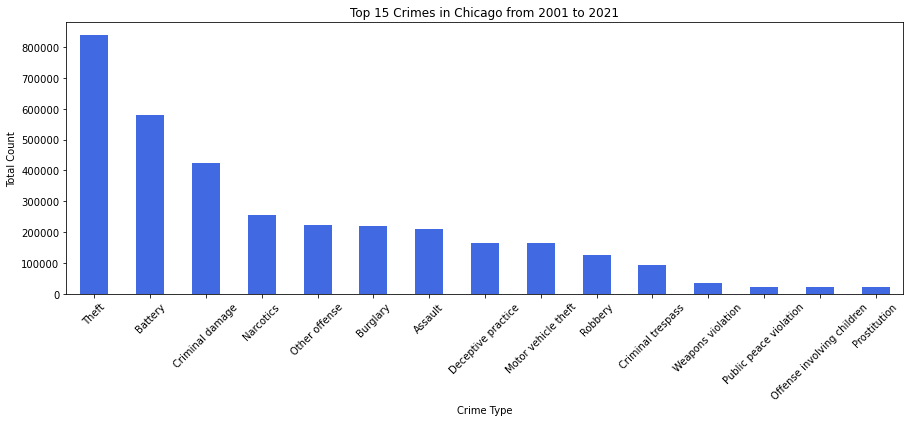

In [714]:
#bar chart for top 15
f,a = plt.subplots(figsize=(15,5))
df_top15_by_type.plot(kind='bar',x='primary_type',y='count',ax=a,color='royalblue',legend=None)
plt.xlabel('Crime Type')
a.tick_params(axis='x',rotation=45)
plt.ylabel('Total Count')
plt.title('Top 15 Crimes in Chicago from 2001 to 2021')

### Crime Count in Each Community Area

In [818]:
df_crime_house_count = df_crime_house.groupby(['community_area', 'community_area_code', 'year','month','price','primary_type'])['primary_type'].count()
df_crime_house_count = df_crime_house_count.to_frame()
df_crime_house_count = df_crime_house_count.rename(columns={'primary_type':'count'}).reset_index()

In [819]:
allcrime = df_crime_house_count.groupby(['community_area'])['count'].sum().reset_index()
allcrime['primary_type'] = "ALL CRIMES"
allcrime = allcrime[['community_area', 'primary_type', 'count']]
crime = df_crime_house_count.groupby(['community_area','community_area_code','primary_type'])['count'].sum().reset_index()
crime_all = crime.append(allcrime)
crime = crime.sort_values(by=['community_area'])

In [820]:
prices = df_crime_house_count.groupby(['community_area'])['price'].mean().reset_index()
prices_median = df_crime_house_count.groupby(['community_area'])['price'].median().reset_index()
prices_median = prices_median.rename(columns={'price':'medprice'})
data = crime.merge(prices[['community_area','price']])
data = data.merge(prices_median[['community_area','medprice']])

In [821]:
data['count'] = np.log(data['count'])
data['price'] = np.log(data['price'])
data['medprice'] = np.log(data['medprice'])
data = data.merge(df_commu[['community_area', 'population']])
data['crime_rate'] = 1000*data['count']/data['population']

### Some correlations

In [824]:
datacorr = data.groupby('primary_type')[['count','price']].corr().reset_index()
datacorr = datacorr[['primary_type', 'count']].sort_values(by = 'count', ascending = True)
datacorr = datacorr.rename(columns={'count':'correlation'})
datacorr = datacorr[datacorr['correlation']!=1]
datacorr.head()

,primary_type,correlation
69,WEAPONS VIOLATION,-0.471498
23,HOMICIDE,-0.448790
47,OFFENSE INVOLVING CHILDREN,-0.382192
37,NARCOTICS,-0.300550
27,INTERFERENCE WITH PUBLIC OFFICER,-0.297409


### Dataset with only weapons violations

As displayed by the previous table, weapon violations appear to have the highest correlation with prices. Therefore, we consider this specific type of crimes as our main crime measure.

In [825]:
data = data[data['primary_type']=='WEAPONS VIOLATION']
data = pd.pivot_table(data, values='count', index=['community_area', 'community_area_code'\
                        ],columns=['primary_type'], aggfunc=np.sum).reset_index()

In [827]:
data = data.merge(prices[['community_area', 'price']])
data = data.merge(df_commu[['community_area', 'population']])
data['price'] = np.log(data['price'])
data['population'] = np.log(data['population'])
data.columns= data.columns.str.lower()

### Linear Regression Model for Housing Price Prediction
We start by presenting the final dataset that we use for analysis. 
Next, we split the sample into training (80%) and testing set (20%). Then we perform the regression model on the training sample, before doing a prediction on the testing sample.

In [838]:
data.head()
summ = data.describe()
summ = summ.round(2)[['weapons violation', 'price', 'population']]
print(summ)

       weapons violation  price  population
count              52.00  52.00       52.00
mean                5.89  12.40       10.24
std                 1.21   0.48        0.70
min                 2.08  11.26        7.98
25%                 5.12  12.09        9.80
50%                 5.93  12.43       10.32
75%                 6.64  12.74       10.85
max                 8.09  13.41       11.45


In [ ]:
# Train the model using the training set
from sklearn.linear_model import LinearRegression

dataX = data[['weapons violation', 'population']]
dataY = data["price"]

dataX_train,dataX_test,dataY_train,dataY_test=train_test_split(dataX,dataY,test_size=0.2)

In [843]:
model = LinearRegression()
model.fit(dataX_train, dataY_train)

ypred_train = model.predict(dataX_train)
ypred_test = model.predict(dataX_test)
residuals = dataY_test - ypred_test

print('Coefficients: \n', model.coef_, model.intercept_)

Coefficients: 
 [-0.28330376  0.41765338] 9.803775850574402


In [844]:
print(model.score(dataX_train,dataY_train))
print(model.score(dataX_test,dataY_test))

0.5260737996738092
0.4877799430986154


In [846]:
# This uses statsmodel to generate summaries of the regressions performed on the training sample
import statsmodels.api as sm
dataX_train = sm.add_constant(dataX_train, prepend=False)
reg_train = sm.OLS(dataY_train, dataX_train)
res_train = reg_train.fit()
print(res_train.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     21.09
Date:                Thu, 13 May 2021   Prob (F-statistic):           6.89e-07
Time:                        13:20:03   Log-Likelihood:                -13.408
No. Observations:                  41   AIC:                             32.82
Df Residuals:                      38   BIC:                             37.96
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
weapons violation    -0.2833      0.04

In [848]:
#Prediction using the testing sample
dataX_test = sm.add_constant(dataX_test, prepend=False)
reg_test = sm.OLS(dataY_test, dataX_test)
res_test = reg_test.fit()
print(res_test.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     6.248
Date:                Thu, 13 May 2021   Prob (F-statistic):             0.0232
Time:                        13:20:22   Log-Likelihood:               0.061183
No. Observations:                  11   AIC:                             5.878
Df Residuals:                       8   BIC:                             7.071
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
weapons violation    -0.4477      0.13

/Users/wilfried/opt/anaconda3/envs/ace592/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
#For printing tables as latex output
for table in res_test.summary().tables:
    print(table.as_latex_tabular())

Next, we create a dataset containing both the actual values for home values and the predicted values using the testing sample. We can see that the residual values are very small. Formally we can also look at other metrics such as the Root Mean Square Error (RMSE).

In [855]:
actual_predict = pd.DataFrame({'Actual': dataY_test, 'Predicted': ypred_test}).head()
actual_predict['resid'] = actual_predict['Actual'] - actual_predict['Predicted']
actual_predict.head()

,Actual,Predicted,resid
4,12.818764,12.514568,0.304196
40,12.737933,12.669976,0.067958
11,11.887604,12.157078,-0.269474
47,12.159894,12.373070,-0.213176
7,12.098573,12.339927,-0.241354


In [861]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(dataY_test, ypred_test))
print('Mean Squared Error:', metrics.mean_squared_error(dataY_test, ypred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(dataY_test, ypred_test)))

Mean Absolute Error: 0.24305678031431022
Mean Squared Error: 0.07598844959672296
Root Mean Squared Error: 0.27566002538765566


In [880]:
from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
lm = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, dataX_train, dataY_train, scoring='r2', cv=folds)

In [881]:
scores

array([ 0.33563755,  0.41961502,  0.63028342,  0.37073241, -4.35606769])

As we can see, while the third set improved on the R-square, the last prediction was quite worse than the original model